# PyTorch를 이용한 GPU에서 Deep Neural Network 학습시키기

### "Deep Learning with Pytorch: Zero to GANs"의 4번째 파트

이 튜토리얼은 [PyTorch](https://pytorch.org)를 이용한 초보자용 딥러닝 학습 튜토리얼 입니다.   
학습하기 위한 최고의 방법은 본인이 코드를 실행하고, 실험해 보는 것이기 때문에 이 튜토리얼은 실용성과 코딩 중심으로 진행됩니다.

본 튜토리얼에선 다음에 대해 다룹니다:
 
 * 히든 레이어가 있는 심층 신경망 생성하기
 * 비선형 활성화 함수 사용하기
 * GPU 사용해 학습 속도 높이기
 * 모델을 향상 시키기 위해 하이퍼 파라미터 실험하기

### 빠른 학습을 위한 GPU 사용

여러분은 만약 여러분의 실행 플랫폼이 NVIDIA에서 만든 GPU와 연결 되어있다면,  [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU)를 여러분의 모델을 더 빠르게 학습시키기 위해 사용할 수 있습니다.

다음 명령어들은 GPU를 사용할 수 있는 플랫폼 목록입니다:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


GPU에 액세스할 수 없거나 GPU가 무엇인지 잘 모를 경우, GPU 없이도 튜토리얼의 모든 코드를 실행할 수 있습니다.

---
## 데이터 준비

이전 튜토리얼에서 저희는 MNIST 손글씨 숫자 이미지를 인식하기 위해 로지스틱 회귀 모델을 학습해 보았고 86%에 달하는 정확도를 달성했습니다.<br>
해당 데이터 셋은 28×28px 흑백 손글씨 숫자 이미지와 이미지가 나타내는 숫자에 대한 레이블로 구성되어 있습니다.

아래 그림은 MNIST 데이터 셋의 몇가지 샘플입니다.

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

저희는 픽셀 강도와 이미지의 레이블 사이에 선형 관계가 있다는 가설 때문에 로지스틱 회귀 모델로 87%의 정확도를 넘는것이 꽤 어렵다는 것을 깨달았습니다.<br>
이 튜토리얼에선 _순방향(feed-forward) 신경망_ 을 사용해 입력과 타겟 사이의 비선형 관계를 포착하여 성능이 향상된 모델을 생성할 것입니다.

먼저 `torch`, `torchvision`, `numpy`, `matplotlib`에서 필요한 모듈과 클래스를 설치하고 가져옵니다.

In [1]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

`MNIST`클래스를 `torchvision.datasets`에서 다운 받을 수 있습니다.

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

4.3%

100.1%

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


0.0%

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw


180.4%C:\Miniconda3\envs\gan\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw
Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


데이터 셋의 이미지 몇 개를 살펴 보겠습니다.<br>
이미지는 1×28×28(색상 채널, 너비, 높이) 형태(shape)의 PyTorch 텐서로 변환되며 `plt.imshow`를 사용해 이미지로 표시할 수 있습니다.<br>
하지만`plt.imshow`는 __채널__ 이 이미지 텐서에서 __마지막 차원__ 이 될 것으로 예상하기 때문에 이미지의 차원을 재정렬하는 `permute` 메서드를 사용합니다.

image.shape: torch.Size([1, 28, 28])
Label: 5


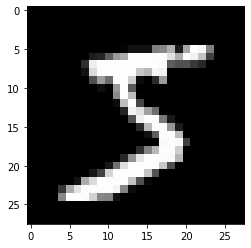

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


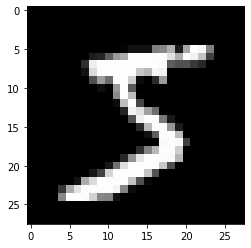

In [5]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

다음으로, `random_split` 함수를 사용해 10000개의 데이터를 검증 세트로 분리합니다.

In [6]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

학습과 검증을 위한 PyTorch 데이터 로더를 생성할 수 있습니다.

In [7]:
batch_size=128

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

`num_workers`와  `pin_memory` 파라미터에 대해 알고 싶으시다면 다음 링크를 확인해보세요:
https://pytorch.org/docs/stable/data.html

`torchvision`의 `make_grid`함수를 사용하여 데이터를 격자로 시각화 해 보겠습니다. <br>
또한 `matplotlib`은 입력 이미지의 채널 차원을 이미지의 마지막 차원으로 가정합니다.<br>
그러므로 `.permute` 메서드를 사용해 채널을 마지막 차원으로 이동시킵니다.<br>

images.shape: torch.Size([128, 1, 28, 28])


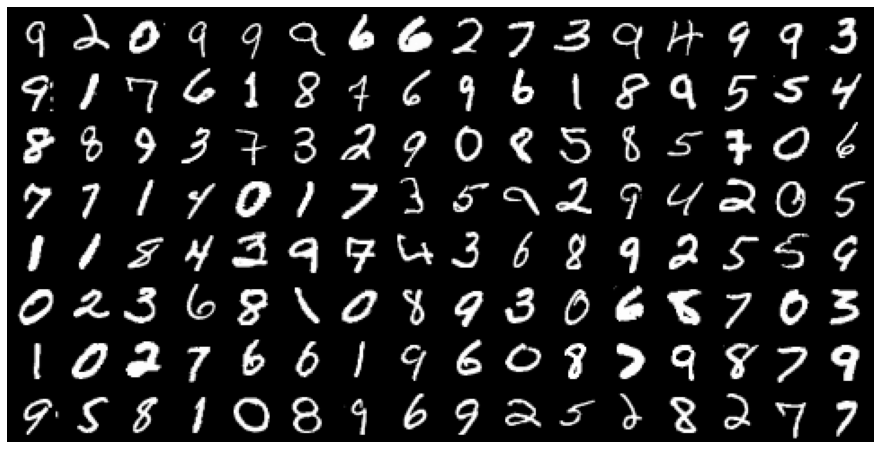

In [9]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## 히든 레이어, 활성 함수, 비선형성

우리는 _hidden layer_ 와 _output layer_ 라는 두 개의 레이어로 구성된 신경망를 만들 것입니다.<br>
또한 두 계층 간에 _활성 함수(activation function)_ 을 사용할 예정입니다. <br>
히든 레이어과 활성 함수이 입력과 출력 사이의 비선형 관계를 포착하는 데 어떻게 도움이 되는지 단계별로 살펴보겠습니다. 

먼저 입력 텐서 배치를 생성 해 보겠습니다. <br>
`1×28×28` 이미지를 `784`크기의 벡터로 _평탄화(flatten)_ 하여 `nn.Linear` 객체로 전달할 수 있습니다.

P.S. `nn.Linear`는 __선형 레이어__ 또는 __Fully connected Layer__ 라는 이름으로 불립니다.

In [10]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


다음으로, _hidden_ 레이어로 사용할 `nn.Linear` 객체를 생성해 보겠습니다.<br>
저희는 히든레이어의 출력 사이즈를 32로 설정하고, 이 사이즈는 모델의 _학습 용량_ 을 변경하기위해 늘리고 줄일 수 있습니다. <br>
이때 _학습 용량_ 은 __모델의 복잡성__ 을 의미합니다.

In [11]:
input_size = inputs.shape[-1]
hidden_size = 32

In [12]:
layer1 = nn.Linear(input_size, hidden_size)

이제 `inputs`을 `layer1`로 전달하여 이미지 배치에 대한 전체 학습 과정 중 중간 단계의 출력을 계산할 수 있습니다.

In [13]:
inputs.shape

torch.Size([128, 784])

In [14]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


`784` 크기의 `input` 이미지 벡터는`layer1`의 전치 된 가중치 행렬과`inputs`의 행렬 곱셈을 수행한 후 편향을 더하여 길이 `32`의 중간 출력 벡터로 변환됩니다. <br>
이를 `torch.allclose`를 사용해 확인 가능합니다.<br>
`torch.allclose`의 자세한 내용은 [해당 PyTorch docs](https://pytorch.org/docs/stable/generated/torch.allclose.html)를 참고 바랍니다.

In [15]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [16]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

그러므로 `layer1_outputs`와 `inputs`는 <font color=red>선형 관계</font>를 가집니다.<br>
즉, `layer_outputs`의 __각 요소__ 는 `inputs`의 __요소들의 가중 합을 한 값__ 을 가집니다.<br>
그러므로 모델을 학습하고 가중치를 변형한다 해도, `layer1`은 `inputs`와 `outputs` 사이의 <font color=red>선형 관계만</font>을 포착할 수 있습니다.

<img src="https://i.imgur.com/inXsLuq.png" width="360">


그 후, __Rectified Linear Unit(ReLU)__ 함수를 출력의 _활성 함수_ 로 사용할 것입니다.<br>
ReLU 함수는 `relu(x) = max(0,x)`와 같은 공식으로 표현되고, 이는 단순히 __텐서 내의 음수의 값들을 0__ 으로 만드는 함수입니다.<br>
아래 그림은 ReLU함수의 그래프를 보여줍니다:


<img src="https://i.imgur.com/yijV4xF.png" width="420">

저희는 `F.relu` 메서드를 사용해 텐서의 요소들에 ReLU를 적용할 수 있습니다.

In [17]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

`layer1_outputs`에 활성 함수를 적용하고, 음수 값들이 0으로 바뀌는지 확인해 봅시다.

In [18]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6856367588043213
min(relu_outputs): 0.0


이제 비선형 함수 ReLU를 적용한 `relu_outputs`를 얻었습니다.<br>
`relu_outputs`는 더이상  `inputs`와 선형 관계를 갖지 않게 됩니다.<br>
`ReLU`를 적용하면 각 입력에 대해 특정 출력 (0이 아닌 값)이 활성화되고 다른 출력 (0인 값)이 비 활성화되기 때문에 이러한 함수를 _활성 함수_ 라 부릅니다.
 
이제 `relu_outputs`에있는 길이가 `hidden_size`인 벡터를 길이가 10 인 벡터로 변환하는 _output_layer_ 를 만들어 보겠습니다.

In [19]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [20]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [21]:
inputs.shape

torch.Size([128, 784])

기대했던 것처럼 `layer2_outputs`는 길이가 10인 벡터의 배치를 가지고 있습니다.<br>
이제 저흰 이 결과값을 이용해 `F.cross_entropy`로 <font color=red>_손실_</font> 을 계산하고, `layer1`과 `layer2`의 가중치를 <font color =blue>_경사 하강법_</font> 을 사용해 조정할 수 있습니다.

In [22]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2993, grad_fn=<NllLossBackward>)

우리의 모델은 `inputs`를 `layer1`을 사용해 선형 변환 후 비선형 활성 함수 `F.relu`를 적용해 `layer2_outputs`를 변환합니다.<br>
출력을 기본 행렬 연산을 사용해 재계산해서 확인해 보겠습니다.

In [23]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [24]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

`outputs`와 `inputs`는 `F.relu` 비선형 활성함수 때문에 선형 관계를 가지지 않습니다.<br>
모델을 훈련시키고 `layer1`과`layer2`의 가중치를 조정하면 이제 __이미지와 레이블 간의 비선형 관계__ 를 포착 할 수 있습니다.<br>
다시 말해, 비 선형을 도입하면 모델은 더욱 강력하고 다양해집니다.<br>
또한 `hidden_size`가 __입력 또는 출력의 차원에 영향을 받지 않기 때문에__, 모델 내의 파라미터 수를 늘리기 위해 이를 변화 시킵니다.<br>
또한 새로운 히든 레이어와 각 히든 레이어 후 같은 비선형 활성 함수를 도입할 수 있습니다.

지금까지 저희가 만든 모델을 <font color=blue>_신경망_</font> 이라고 부릅니다.<br>
_심층 신경망_ 은 간단히 말해서 __1개 또는 더 많은 히든 레이어__ 가 있는 신경망입니다.<br>
실제로, [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html)에 따르면 충분히 크고 깊은 신경망은 임의의 함수, 즉 입력과 타겟 사이의 풍부하고 복잡한 _비선형 관계_ 를 계산할 수 있습니다. 다음은 몇 가지 예입니다:

* 이미지를 보고 개, 고양이 판별 (또는 [기타 등등](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* 노래를 10초간 듣고 장르 판별
* 도로의 영상을 사용해 자동차 자율 주행
* 언어 번역
* 음성을 텍스트로 변환하거나 텍스트를 음성으로 변환
* 기타 등등

무작위로 초기화된 행렬을 입력과 곱하고, 비선형 활성 함수를 적용하고 경사 하강법을 사용해 가중치를 반복적으로 조정하는 간단한 과정이 어떻게 좋은 결과를 가져올 수 있는지는 아직 이해하기 어렵습니다.<br>
_딥러닝 모델_ 들은 보통 수백만개의 파라미터들을 가지고 있고 이러한 많은 수의 파라미터들은 저희 인간의 뇌가 이해하는것 보다 훨씬 어려운 관계를 파악할 수 있습니다.

두 선형 레이어 사이에 비선형 활성화를 포함하지 않았다면 입력과 출력 사이의 최종 관계는 여전히 선형입니다.<br>
간단한 연산 재구성으로 이를 확인 할 수 있습니다.

In [25]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [26]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [27]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [28]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

지금까지 저희는 하나의 히든 레이어를 가진 신경망을 만들었습니다.<br>
저희는 다음과 같은 작업들을 해주었습니다:

* 한 개의 `nn.Linear` 객체를 사용하여 입력 배치(픽셀 강도)를 출력(클래스 확률)으로 변환하는 대신 두 개의`nn.Linear` 객체를 사용합니다. 이들 각각을 네트워크에서 _레이어(layer)_라고합니다.


* 이때 레이어에서 출력되는 행렬의 형태(shape)는 `batch_size×hidden_size`가 되고 `hidden_size`는 사용자의 임의로 구성할 수 있습니다. <br> 앞에서 첫 번째 레이어(히든레이어)는 입력 행렬의 형태를 `batch_size × 784`로 변환해 줍니다. 


* 그 후 비선형 _활성 함수_ 를 레이어와 레이어 사이 중간 출력에 적용해 주었습니다. <br> 이 활성 함수는 행렬의 개별 요소에 변환을 가합니다.


* 활성 함수의 결과는 이전과 같은 `batch_size×hidden_size`가 되고 이 행렬을 두 번째 레이어(출력 레이어)에 넣어줍니다.<br> 이 두 번째 레이어는 입력 행렬을 `batch_size×10`으로 변환해 출력해 줍니다. <br> 우리는 이 출력을 이용해 손실을 계산하고 경사 하강법으로 가중치를 조정합니다.

위에서 논의한 것처럼, 우리의 모델은 1개의 히든 레이어를 가질 것 입니다. 아래는 저희 모델의 구조도입니다:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">

이제 PyTorch의 `nn.Module` 클래스를 상속해 모델을 정의해보겠습니다.

In [29]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

모델의 배치 입력의 예측 정확도를 계산하는 `accuracy` 함수를 정의할 필요가 있습니다.<br>
이 함수는 위 코드의 `validation_step`에서 사용될 것입니다.

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

이제 저희는 `hidden_size` = 32인 히든 레이어를 가진 모델을 만들 것입니다.

In [31]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [32]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

이제 모델의 파라미터를 확인해 봅시다.<br>
한 레이어당 __1개의 가중치와 1개의 편향 행렬__ 을 가집니다.

In [33]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


이제 생성한 모델의 출력을 생성해 보겠습니다.<br>
데이터 셋에서 가져온 128개의 데이터를 가진 배치를 모델에 넣어 줄 것입니다.

In [34]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3160431385040283
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0473,  0.2054,  0.0424, -0.1158, -0.1480,  0.1637, -0.0697, -0.1110,
         -0.1249, -0.0596],
        [ 0.0333,  0.1732, -0.0049, -0.1415, -0.1106,  0.1273, -0.0580, -0.0968,
         -0.1085, -0.0383]])


## GPU 사용

모델과 데이터셋이 커진다면, 저희는 GPU를 사용해야 적당히 많은 시간을 투자해 모델을 학습시킬수 있습니다.<br>
GPU들은 비싼 실수 행렬 연산을 빠르게 수행하도록 최적화된 수백개의 코어를 가지고 있고, 이러한 특징은 GPU를 심층 신경망 학습에 이상적이게 만듭니다.<br>
저희는 [Google Colab](https://colab.research.google.com/)등에서 무료 GPU를 사용할 수 있습니다.

만약 GPU를 사용 가능한지, 필요한 NVIDIA CUDA 드라이버가 설치되어 있는지는 `torch.cuda.is_available`을 사용하여 확인할 수 있습니다.

In [35]:
torch.cuda.is_available()

True

GPU를 사용 가능한 경우 GPU를 사용하고 그렇지 않은 경우 CPU를 사용하도록하는 함수를 정의해 보겠습니다.

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [37]:
device = get_default_device()
device

device(type='cuda')

다음으로, 데이터와 모델을 정해진 장치 (CPU 또는 GPU)로 이동시키는 함수를 정의해 보겠습니다.

In [38]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [39]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


마지막으로 현재 데이터 로더를 감싸고 데이터 배치들을 선택된 장치로 옮겨주는 `DeviceDataLoader` 클래스를 정의하겠습니다.<br>
재밌게도, PyTorch 데이터로더를 만들기 위해 상속을 할 필요가 없습니다.<br>
필요한건 오직 데이터 배치를 검색하는 `__iter__` 메서드와 배치의 수를 가져오는 `__len__` 메서드만 정의해주면 됩니다.

In [40]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Python에서 `yield`라는 키워드는 `for` 반복문에 사용할 수 있는 생성기 함수를 만드는데 사용됩니다.

In [41]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


이제 `DeviceDataLoader`를 사용해 데이터로더를 감싸 데이터를 선택된 Device로 편리하게 옮길 수 있습니다.

In [42]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

텐서들은 __`device` 속성을 `cuda`로 바꾸어__ GPU로 옮길 수 있습니다.<br>
`valid_dl`을 사용해 데이터의 위치를 확인해보겠습니다.

In [43]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([5, 4, 9, 1, 7, 9, 4, 0, 2, 2, 5, 2, 6, 3, 5, 9, 4, 3, 8, 2, 5, 8, 7, 2,
        1, 8, 0, 7, 3, 6, 6, 1, 2, 0, 1, 1, 9, 8, 7, 8, 2, 6, 9, 7, 4, 8, 2, 6,
        2, 6, 3, 6, 7, 0, 1, 7, 0, 7, 2, 8, 3, 1, 7, 7, 1, 9, 7, 5, 2, 0, 5, 4,
        1, 5, 2, 3, 0, 6, 6, 1, 0, 2, 7, 8, 7, 9, 7, 7, 2, 3, 1, 2, 5, 9, 5, 3,
        1, 9, 3, 1, 7, 9, 4, 5, 9, 8, 7, 2, 3, 9, 0, 8, 1, 1, 2, 8, 5, 5, 9, 8,
        5, 3, 1, 0, 8, 0, 1, 5, 8, 6, 1, 4, 4, 9, 9, 1, 9, 9, 1, 0, 0, 6, 6, 7,
        1, 5, 7, 6, 6, 9, 4, 7, 8, 0, 1, 2, 4, 6, 5, 2, 6, 8, 4, 8, 7, 5, 9, 1,
        4, 8, 9, 1, 0, 2, 4, 4, 7, 6, 9, 6, 1, 9, 3, 0, 5, 0, 7, 4, 2, 1, 3, 4,
        4, 6, 0, 4, 9, 0, 5, 8, 4, 5, 4, 3, 7, 2, 3, 3, 7, 9, 3, 1, 2, 3, 5, 5,
        2, 2, 2, 7, 4, 8, 7, 9, 9, 6, 1, 6, 7, 3, 7, 1, 7, 7, 2, 1, 0, 3, 6, 9,
        7, 5, 4, 3, 1, 5, 6, 5, 1, 9, 4, 5, 2, 9, 3, 5], device='cuda:0')


## 모델 학습

경사 하강법을 사용하여 모델을 학습시키고 검증 세트에서 성능을 평가하기 위한 `fit`와 `evaluate` 두 가지 함수를 정의합니다.

In [44]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

모델을 학습하기 전, 저흰 데이터와 모델의 파라미터(가중치와 편향)은 같은 장치(CPU 또는 GPU)에 위치해 있는지 확인해야합니다.<br>
`to_device` 함수를 사용하여 모델의 매개 변수를 적절한 장치로 이동할 수 있습니다.

In [45]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

모델이 초기 가중치와 편향을 사용하여 검증 세트에서 어떻게 수행되는지 알아보겠습니다.

In [46]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3106441497802734, 'val_acc': 0.10498046875}]

초기 정확도는 10% 언저리로, 랜덤 초기화된 모델의 양상을 보이고있습니다.(10개 클래스중 1개를 랜덤으로 고르는 것이므로...)

모델을 약간 __높은__ 학습률인 0.5로 5 epoch 학습하고 결과를 보도록 하겠습니다.<br>

In [47]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2566, val_acc: 0.9227
Epoch [1], val_loss: 0.1763, val_acc: 0.9491
Epoch [2], val_loss: 0.1516, val_acc: 0.9552
Epoch [3], val_loss: 0.1596, val_acc: 0.9505
Epoch [4], val_loss: 0.1362, val_acc: 0.9591


정확도가 96%로 꽤 좋습니다! <br>
모델을 0.1 학습률로 5 epoch 더 학습하여 정확도를 향상시켜 보겠습니다.

In [48]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1196, val_acc: 0.9637
Epoch [1], val_loss: 0.1186, val_acc: 0.9646
Epoch [2], val_loss: 0.1179, val_acc: 0.9648
Epoch [3], val_loss: 0.1176, val_acc: 0.9644
Epoch [4], val_loss: 0.1158, val_acc: 0.9656


우리는 손실과 정확도의 그래프를 그려 모델이 어떻게 학습되는지에 대해 알아보겠습니다.

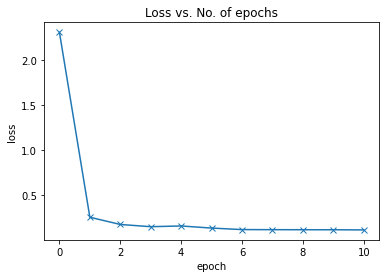

In [49]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

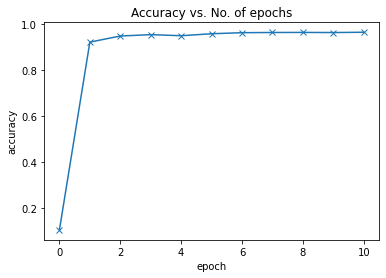

In [50]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

이번에 생성한 모델은 로지스틱 회귀 모델(86%)보다 훨씬 좋은 성능을 보입니다! <br>

---

이 모델은 97%의 정확도에 빠르게 도달하지만 그 이상으로 개선되지는 않습니다.<br>
더 정확도를 향상시키기 위해서 모델의 __히든 레이어의 사이즈를 늘리거나__, 히든 레이어와 __활성 함수__를 함께 추가하여 모델을 좀 더 강력하게 만들 필요가 있습니다.<br>
이 두 가지 방법을 모두 시도해보고 어느 것이 더 잘 작동하는지 확인하시기 바랍니다.<br>

## 단일 이미지 테스트

지금까지 모델의 전체적인 정확도를 주로 보았지만, _일부 샘플 이미지_ 에서의 모델의 결과를 살펴보는 것도 좋습니다. <br>
사전 정의된 테스트 데이터 세트인 10000개의 영상으로 모델을 테스트해 보겠습니다.<br>
먼저 테스트 데이터 셋을 `ToTensor`변환으로 적용하도록 재생성 합니다.

In [51]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

단일 이미지 텐서의 레이블을 예측하는 `predict_image`함수를 정의해 보겠습니다.

In [52]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

몇가지 이미지에 더 실험해 보겠습니다.

Label: 7 , Predicted: 7


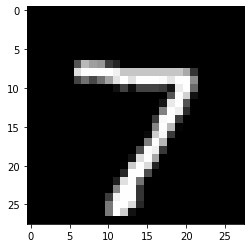

In [53]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


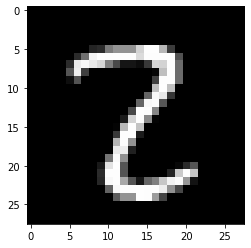

In [54]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


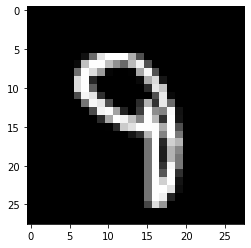

In [55]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

모델의 성능이 저조한 부분을 식별하면 더 많은 학습 데이터를 수집하고 모델의 복잡성을 높이거나 낮추며 과대 파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있습니다. <br>
마지막 단계로 테스트 세트에서 모델의 전체 손실과 정확도를 살펴 보겠습니다.<br>

In [56]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10188106447458267, 'val_acc': 0.968457043170929}

일반적으로 테스트 셋의 정확도와 손실은 validation 셋에서와 비슷할 것으로 예상됩니다.<br>
그렇지 않다면, 테스트 세트와 유사한 데이터와 분포를 가진 더 나은 validation 셋이 필요할 수 있습니다.

## 연습 과제

짧은 시간 내에 훌륭한 기계 학습 모델을 교육하려면 여러번의 연습과 많은 경험이 필요합니다. <br>
다양한 데이터셋, 모델 및 하이퍼 파라미터로 실험해 보는것이 이 기술을 습득하는 가장 좋은 방법입니다.

## 요약과 더 읽을 거리

이번 튜토리얼에서 다룬 주제들의 요약입니다:

* 이전 튜토리얼에서 다룬 로지스틱 회귀 모델의 성능을 <font color=blue>능가</font>하기위한 한 개의 히든레이어를 가진 신경망을 만들었습니다.<br> 또한 ReLU 활성화 함수를 사용해 비선형성을 도입하였고, 이것은 모델이 `inputs`(픽셀 강도)와 `outputs`(클래스 확률) 사이의 복잡한 관계를 배울 수 있게 합니다.


* __GPU의 이점__ 을 누리기 위한 `get_default_device`나 `to_device`, `DeviceDataLoader`와 같은 데이터나 모델의 파라미터를 적절한 장치로 옮기는  함수를 정의했습니다.


* 우리는 `fit` 함수를 정의해 똑같은 학습 루프를 사용할 수 있었습니다. `fit`함수 : 모델을 훈련 후 검증 데이터 셋을 사용해 모델을 평가하는 함수



이 튜토리얼에는 아직 하지 않은 많은 실험들이 있습니다.<br>
따라서 주피터의 상호작용 특성을 활용하여 다양한 매개 변수를 활용할 것을 권장합니다. 다음은 몇 가지 아이디어입니다:

* __히든 레이어의 사이즈__ 를 변경하거나 __히든 레이어를 추가__ 해 더 높은 정확도를 얻을 수 있는지 알아보기

* __배치 사이즈와 학습률__ 을 변경해 더 적은 epoch에 동일한 정확도를 얻을 수 있는지 알아보기

* CPU와 GPU의 __학습 시간__ 을 비교해보기. (데이터 세트와 모델의 크기를 기반으로 비교해보기)

* [CIFAR10 또는 CIFAR100 데이터셋](https://www.cs.toronto.edu/~kriz/cifar.html) 등 다른 데이터셋에 모델을 만들어보기


더 읽을거리:

* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), 위에서 말한 Universal Approximation Theorem에 대한 내용

* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - 신경망이 무엇이며 중간 계층의 의미에 대한 시각적이고 직관적인 소개

* [Stanford CS229 Lecture notes on Backpropagation](http://cs229.stanford.edu/notes/cs229-notes-backprop.pdf) - 여러 레이어가있는 신경망에 대해 기울기가 계산되고 가중치가 업데이트되는 방식에 대한보다 수학적 관점에서의 이해